In [1]:
import statsmodels.api as sm

import pandas as pd
import numpy as np
import seaborn as sns

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Todos
 - Feature creation 
  - [x] add polynomial features
  - [ ] apply more transformations to the variables (log, etc.)
  - [ ] Do some dimensionality reduction / cluster to
 - Hyperparameter tuning
  - [ ] Grid search for all classifiers and meta classfiers
 - Model stacking / Pipelining / Ensembling
  - [ ] Review Kaggle posts / [approaches to model stacking](http://blog.kaggle.com/2016/12/27/a-kagglers-guide-to-model-stacking-in-practice/) 
  - [ ] Review Kaggle posts / approaches to multi-model voting
 - Model Diagnostics
  - [ ] run logistic regression (or another classifier) to get class probabilities.  Identify the data points that are getting low probabilities
  - [ ] create a pipeline for identifying the miss-classified datapoints and investigate the features that may be causing issues
  - [ ] See this [kaggle post](https://www.kaggle.com/ngutten/otto-group-product-classification-challenge/visualizing-mistakes/code)

In [10]:
df = pd.read_csv('../data/clean/surveys.csv')

In [108]:
svo = df.loc[
    (df.svo.notnull()) & 
    (df.income!= 'Prefer not to answer') & 
    (df.ip != '104.200.153.94') &
    (df.age != 1234) & 
    (df.indoor.notnull())
, :]
svo.loc[:, 'income'] = svo.loc[:, 'income'].astype(int)
svo.loc[:, event_cols] = svo.loc[:, event_cols].fillna(0)
svo.reset_index(drop=True, inplace=True)

### Features

In [109]:
event_cols = [
    'ev0', 'ev1', 'ev2',
    'ev3', 'ev4', 'ev5',
    'i0', 'i1', 'i2', 'i4'
]

In [110]:
interest_cols = [
    'health_fitness', 'indoor',
    'life_style', 'nature', 'outdoor',
    'performance_arts', 'sports', 'other'
]

In [111]:
demo_cols = [
    'age', 'income', 
    'education', 'politics',
    'religiosity', 'trust_development',
    'relationship_development',
    'dependence_development',
]

In [112]:
meta_cols = [
    'durationSeconds'
]

In [113]:
target_cols = interest_cols + demo_cols + meta_cols + event_cols

In [114]:
sdf = svo.loc[:, ['svo'] + target_cols].dropna(axis=1, how='all')
tdf = svo.loc[:, ['type'] + target_cols].dropna(axis=1, how='all')

In [115]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import minmax_scale

In [116]:
X = sdf.ix[:, 1:]

In [117]:
X_scaled = minmax_scale(X)

In [118]:
y_svo = sdf.svo.as_matrix()
y_type = pd.factorize(tdf.type.as_matrix())[0]

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y_type, test_size=.25)

### Feature Engineering

In [20]:
from sklearn.preprocessing import PolynomialFeatures

In [21]:
poly = PolynomialFeatures(2)

In [22]:
EX = poly.fit_transform(X)

### OLS

In [23]:
# Y = list(svo.svo)

In [24]:
# X = list(svo.trust_development)

#### Scikits

In [30]:
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import r2_score

In [31]:
from sklearn.linear_model import LinearRegression

In [32]:
estimator = LinearRegression()

In [33]:
# estimator.fit(X, y_svo)
score = cross_val_score(estimator, X, y_svo, cv=10, scoring='mean_squared_error').mean()
print("Score with the entire dataset = %.2f" % score)

Score with the entire dataset = -134.93


#### Statsmodels

In [153]:
model = sm.OLS(y_svo, X)

In [154]:
results = model.fit()

In [155]:
summary = results.summary()

In [156]:
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     101.1
Date:                Sat, 01 Apr 2017   Prob (F-statistic):          9.52e-191
Time:                        22:48:21   Log-Likelihood:                -2180.6
No. Observations:                 563   AIC:                             4415.
Df Residuals:                     536   BIC:                             4532.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            -0.2986      1.124     -0.266      0.791        -2.507     1.910
x2             3.5771      1.170      3.058      0.002         1.279     5.875
x3             2.1191      1.131      1.873      0.062        -0.103     4.341
x4             1.1511      1.156      0.996      0.320        -1.120     3.422
x5            -1.2029      1.168     -1.029      0.304        -3.498     1.092
x6             0.3322      1.088      0.305      0.760        -1.805     2.469
x7             1.2547      1.057      1.187      0.236        -0.822     3.331
x8             0.2574      2.851      0.090      0.928        -5.342     5.857
x9             0.0013      0.002      0.853      0.394        -0.002     0.004
x10            0.0463      0.174      0.265      0.791        -0.296     0.389
x11            1.1465      0.395      2.903      0.004         0.371     1.922
x12           -0.5735      0.425     -1.351      0.177        -1.408     0.261
x13            1.0897      0.390      2.792      0.005         0.323     1.856
x14            1.8662      0.556      3.359      0.001         0.775     2.958
x15            1.6633      0.499      3.332      0.001         0.683     2.644
x16           -0.6330      0.522     -1.212      0.226        -1.659     0.393
x17            0.0526      0.014      3.842      0.000         0.026     0.080
x18           -0.0062      0.004     -1.630      0.104        -0.014     0.001
x19            0.0202      0.003      6.630      0.000         0.014     0.026
x20           -0.0026      0.005     -0.563      0.573        -0.012     0.006
x21            0.0081      0.005      1.520      0.129        -0.002     0.019
x22           -0.0728      0.008     -9.144      0.000        -0.088    -0.057
x23            0.0208      0.007      3.044      0.002         0.007     0.034
x24           -0.9813      0.800     -1.227      0.220        -2.552     0.590
x25           -0.1815      1.204     -0.151      0.880        -2.546     2.183
x26           -4.9489      2.349     -2.106      0.036        -9.564    -0.334
x27            0.9115      6.071      0.150      0.881       -11.014    12.837
==============================================================================
Omnibus:                       11.793   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               13.915
Skew:                          -0.254   Prob(JB):                     0.000951
Kurtosis:                       3.579   Cond. No.                     4.99e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.99e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
""

### Random Forest Regressor

In [89]:
from sklearn.ensemble import RandomForestRegressor

In [90]:
estimator = RandomForestRegressor(random_state=0, n_estimators=100)

In [91]:
score = cross_val_score(estimator, X, y_svo, cv=10, scoring='mean_squared_error').mean()
print("Score with the entire dataset = %.2f" % score)

Score with the entire dataset = -99.37


In [92]:
estimator.fit(X, y_svo)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [93]:
y_pred = estimator.predict(X)

In [94]:
r2_score(y_svo, y_pred)

0.92640296913037368

### Ensemble Classifiers

In [175]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [332]:
rf_clf = RandomForestClassifier(n_estimators=300)
gb_clf = GradientBoostingClassifier(n_estimators=300)
# ab_clf = AdaBoostClassifier()

In [25]:
score = cross_val_score(gb_clf, X, y_type, cv=10).mean()
print("Score with the entire dataset = %.2f" % score)

Score with the entire dataset = 0.79


In [379]:
rf_clf.fit(X_train, y_train)
gb_clf.fit(X_train, y_train)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [163]:
y_pred = estimator.predict(X_test)

In [173]:
imp = pd.Series(estimator.feature_importances_)

In [175]:
# feats = pd.DataFrame({'col':target_cols, 'imps': imp})

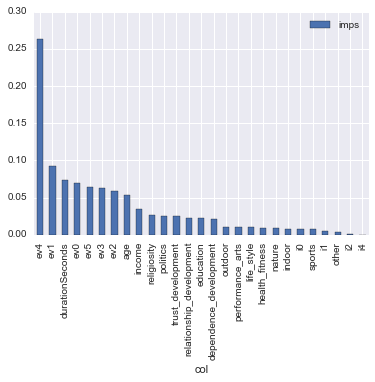

In [52]:
feats.sort_values('imps', ascending=False).plot(
    kind='bar', x=feats.sort_values('imps', ascending=False).col)

### Support Vector Machine

In [44]:
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV

In [336]:
svc_clf = SVC(C=10, kernel='linear', probability=True)

In [62]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

In [63]:
clf = GridSearchCV(estimator, param_grid)

In [337]:
svc_clf.fit(X_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [87]:
y_pred2 = estimator2.predict(X_test)

In [132]:
# clf.best_params_

In [178]:
# clf.best_estimator_

In [179]:
# clf.best_score_

In [177]:
# score = cross_val_score(clf.best_estimator_, X, y_type, cv=10).mean()
# print("Score with the entire dataset = %.2f" % score)

### KNN

In [36]:
from sklearn.neighbors import KNeighborsClassifier

In [37]:
knn_clf = KNeighborsClassifier(n_neighbors=5)

In [67]:
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [34]:
score = cross_val_score(knn_clf, X, y_type, cv=10).mean()
print("Score with the entire dataset = %.2f" % score)

Score with the entire dataset = 0.78


### Voting Classifier

In [38]:
from sklearn.ensemble import VotingClassifier

In [57]:
vote_clf = VotingClassifier(
    estimators=[
        ('rf', rf_clf), ('gb', gb_clf), ('knn', knn_clf)
    ], voting='soft', weights=[1, 2, 2])

In [58]:
score = cross_val_score(vote_clf, X, y_type, cv=3).mean()
print("Score with the entire dataset = %.2f" % score)

Score with the entire dataset = 0.79


### Diagnostics and Model Checking

In [59]:
## See how the model performs with more data

In [60]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [61]:
# classification_report(y_test, y_pred, target_names=f[1])

In [62]:
confusion_matrix(y_test, y_pred)

NameError: name 'y_pred' is not defined

In [122]:
adf = pd.DataFrame({'train': y_test, 'test': y_pred})

In [125]:
adf['loss'] = adf.apply(lambda r: 1 if r['test'] == r['train'] else 0, axis=1)

In [138]:
f = pd.factorize(tdf.type.as_matrix())

In [150]:
# adf.replace({
#     0: 'individualistic',
#     1: 'prosocial',
#     2: 'altruistic',
#     3: 'competitive'
# })

### Learning Curve

In [377]:
scores = []
sizes = range(50, 550, 10)
for size in sizes:
    sample = svo.sample(size)
    df = sample.loc[:, ['type'] + target_cols].dropna(axis=1, how='all')
    y = pd.factorize(df.type.as_matrix())[0]
    X = df.ix[:, 1:].as_matrix()
    score = cross_val_score(gb_clf, X, y, cv=3).mean()
    scores.append(score)

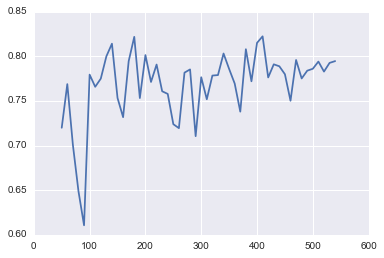

In [378]:
plt.plot(sizes, scores)

### ROC curve

In [71]:
from sklearn.metrics import roc_curve, auc

In [365]:
X_train, X_test, y_train, y_test = train_test_split(X, y_type, test_size=.25)

In [370]:
probs = gb_clf.predict_proba(X_test)
preds = probs[:,1]

In [371]:
probs2 = svc_clf.predict_proba(X_test)
preds2 = probs2[:,1]

In [372]:
probs3 = knn_clf.predict_proba(X_test)
preds3 = probs3[:,1]

In [382]:
probs4 = rf_clf.predict_proba(X_test)
preds4 = probs4[:,1]

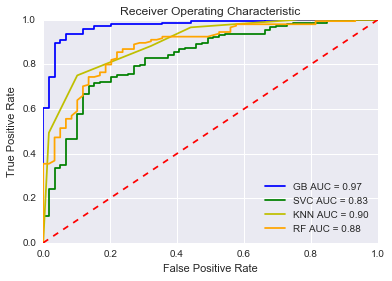

In [385]:
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

fpr2, tpr2, threshold = roc_curve(y_test, preds2)
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, threshold = roc_curve(y_test, preds3)
roc_auc3 = auc(fpr3, tpr3)

fpr4, tpr4, threshold = roc_curve(y_test, preds4)
roc_auc4 = auc(fpr4, tpr4)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'GB AUC = %0.2f' % roc_auc)
plt.plot(fpr2, tpr2, 'g', label = 'SVC AUC = %0.2f' % roc_auc2)
plt.plot(fpr3, tpr3, 'y', label = 'KNN AUC = %0.2f' % roc_auc3)
plt.plot(fpr4, tpr4, 'orange', label = 'RF AUC = %0.2f' % roc_auc4)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [186]:
probs = pd.Series(preds).apply(np.max)

In [188]:
adf['prob'] = probs

In [196]:
# adf[adf.loss==0]

### Identifying misclassified points

In [73]:
# Classifiers
rf_clf = RandomForestClassifier(n_estimators=300)
gb_clf = GradientBoostingClassifier(n_estimators=300)
svc_clf = SVC(C=10, kernel='linear')
knn_clf = KNeighborsClassifier(n_neighbors=5)

In [205]:
clf = knn_clf

In [206]:
min_count = 0
runs = []
rdf = None
## train a classifier on anew training and testing set
while min_count <= 10:
    # Create placeholder vector
    run = np.full((1,X.shape[0],), np.nan)
    X_train, X_test, y_train, y_test = train_test_split(X, y_type, test_size=.25)
    # tet on the entire data set
    clf.fit(X_train, y_train)
    ## make predictions with the classifier
    y_pred = clf.predict(X_test)
    ## check if they're correct or incorrect
    misclassified = ~np.equal(y_pred, y_test)
#     print(pd.Series(misclassified).value_counts())
    # for each data point in the test set, if it's misclassified set the it's it's datapoint 
    # misclassified
    for dix, vix in enumerate(X_test.index):
        run[0][vix] = 1 if misclassified[dix] else 0
    runs.append(run[0])
    rdf = pd.DataFrame(runs)
    min_count = np.min(rdf.count())

In [457]:
hard_cases = rdf.mean()[rdf.mean() > .85].index
easy_cases = rdf.mean()[rdf.mean() == 0].index

In [458]:
svo.loc[hard_cases, 'case'] = 'hard'
svo.loc[easy_cases, 'case'] = 'easy'

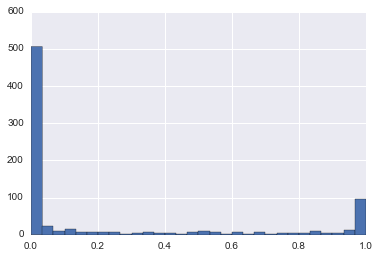

In [238]:
# Distribution of incorrect classifications
rdf.mean().hist(bins=30)
plt.title("Histogram of Data Point Misclassification Percentages")

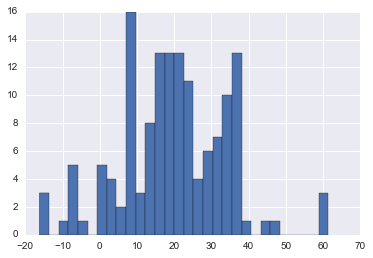

In [249]:
hard = svo.ix[hard_cases].svo.hist(bins=30)

In [274]:
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

In [303]:
cdf = svo.loc[:, ['case'] + target_cols]

In [304]:
X_clust = cdf.ix[cdf.case.notnull(), 1:]

In [305]:
X_clust_scaled = min_max_scaler.fit_transform(X_clust)

In [306]:
mds = MDS(2, max_iter=100, n_init=1)
tsne = TSNE(n_components=2, perplexity=50)
pca = PCA(n_components=2)

In [307]:
clust = tsne
X_mds = clust.fit_transform(X_clust_scaled)

In [308]:
mdf = pd.DataFrame({
    'x': X_mds.transpose()[0], 
    'y': X_mds.transpose()[1], 
    'case': cdf[cdf.case.notnull()].case
})

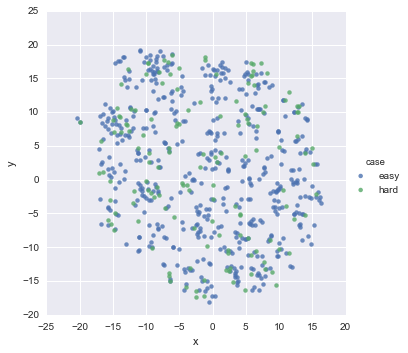

In [309]:
plt.figure(figsize=(12, 12))
sns.lmplot(x='x', y='y', hue='case',
           fit_reg=False, data=mdf, scatter_kws={'alpha':0.8})

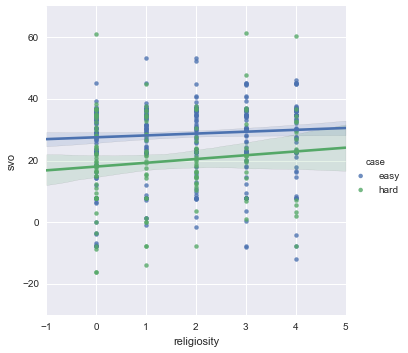

In [323]:
sns.lmplot(x='religiosity', y='svo', data=svo[svo.age < 100], hue='case')

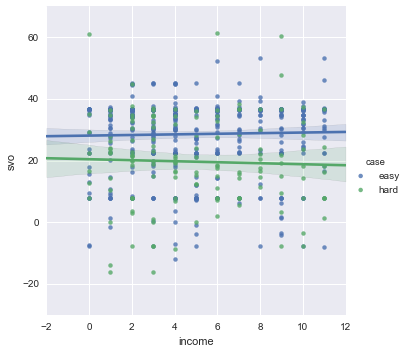

In [321]:
sns.lmplot(x='income', y='svo', data=svo[svo.age < 100], hue='case')

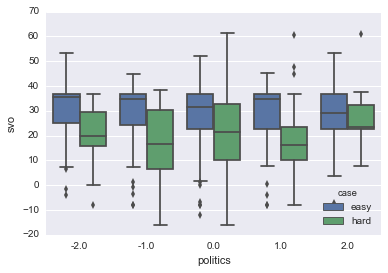

In [330]:
sns.boxplot(x='politics', y='svo', data=svo[svo.age < 100], hue='case')

In [450]:
gb_hard_clf = GradientBoostingClassifier(n_estimators=300)
svc_hard_clf = svc_clf = SVC(C=1, kernel='linear', probability=False)

In [451]:
y_case = pd.factorize(svo.case)[0]

In [452]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(svo[target_cols], y_case, test_size=.25)

In [453]:
svc_hard_clf.fit(X_train_c, y_train_c)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [454]:
# score = cross_val_score(gb_hard_clf, , y_type, cv=3).mean()
# print("Score with the entire dataset = %.2f" % score)

In [455]:
case_pred = svc_hard_clf.predict(X_test_c)

In [456]:
confusion_matrix(case_pred, y_test_c)

array([[  7,   4,   4],
       [ 36, 116,  33],
       [  0,   1,   2]])

In [400]:
score = cross_val_score(gb_hard_clf, svo[target_cols], y_case, cv=3).mean()
print("Score with the entire dataset = %.2f" % score)

Score with the entire dataset = 0.65


In [402]:
np.argmax(gb_hard_clf.feature_importances_)

16

target_cols[16]

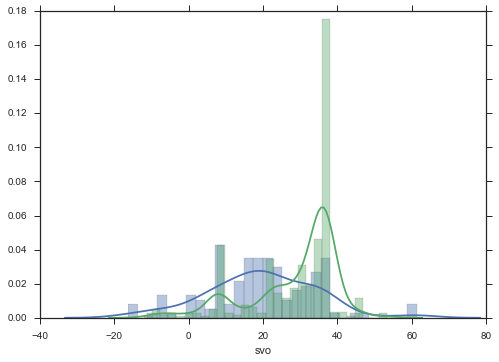

In [411]:
# sns.set(style="ticks", color_codes=True)
# g = sns.FacetGrid(svo[svo.notnull()], col="case")
# g = g.map(plt.hist, "svo", bins=30)
sns.distplot(svo[svo.case=='hard'].svo, bins=30)
sns.distplot(svo[svo.case=='easy'].svo, bins=30)

In [344]:
# sns.lmplot(x='ev4', y='svo', data=svo, hue='case')

In [302]:
# X = cluster_df.ix[:, 1:].as_matrix()
# X_scaled = min_max_scaler.fit_transform(X)

In [174]:
# np.in1d(y_pred, y_test)

### Reviewing classification probabilities

In [120]:
# X_train, X_test, y_train, y_test = train_test_split(X, y_type, test_size=.25)
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)
# misclassified = np.in1d(y_pred, y_test)
# placeholder = np.full((1,X.shape[0],), np.nan)
# for dix, vix in enumerate(X_test.index):
#     placeholder[0][vix] = 1 if misclassified[dix] else 0